# A first look convnet

Here we will look at the first ~400 image cutouts for the α.100 HI data set. We'll test simple models and see how promising results are!

In [1]:
from fastai import *
from fastai.vision import *

from glob import glob

%matplotlib inline

PATH = os.path.abspath('..')

# Making the toy catalog

In [2]:
df = pd.read_csv(f'{PATH}/data/a100.code12.tab1.180315.csv')
df.sample(5)

,AGCNr,Name,RAdeg_HI,DECdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,sigW,W20,HIflux,sigflux,SNR,RMS,Dist,sigDist,logMH,siglogMH,HIcode
2951,1146,........,24.09542,10.53556,24.10042,10.53583,3526,161,6,178,1.66,0.07,13.1,2.24,48.1,2.5,8.96,0.07,1
7966,192542,........,135.08710,7.32472,135.09917,7.30778,17651,324,28,508,2.72,0.11,13.3,2.54,256.4,2.3,10.62,0.05,1
27973,320109,428-062.,333.86584,15.57861,333.86960,15.56889,10121,289,55,352,0.92,0.09,5.6,2.17,139.5,2.3,9.63,0.06,2
17831,227286,........,187.36792,33.48083,187.35583,33.48000,9289,20,6,224,0.35,0.03,8.2,1.98,136.4,2.4,9.19,0.06,1
13649,6245,I.676...,168.17125,9.06528,168.16583,9.05583,1421,177,3,141,1.39,0.07,11.0,2.12,17.5,3.6,8.00,0.18,1


In [3]:
ids = np.array([os.path.basename(fn).strip('.jpg') for fn in glob(f'{PATH}/images/*.jpg')], dtype=int)
print(ids[:5])

[100838 100056     43 102243 102629]


In [4]:
# isolate those that have imaging (AGC ids match the JPG files) && those with HIcode == 1
df = df[df.AGCNr.isin(ids) & (df.HIcode == 1)]

# save out two-column table of names, HI mass
train_label_csv = f'{PATH}/data/example_400gals.csv'

table = df[['AGCNr', 'logMH']]
table.to_csv(train_label_csv, index=False)

# Compile DataBunch

In [5]:
df = pd.read_csv(train_label_csv)
df.sample(5)

,AGCNr,logMH
163,102304,9.59
21,105297,9.02
146,104297,9.78
200,101903,10.05
178,105041,10.12


In [6]:
bs = 16
sz = 112

In [7]:
src = (ImageItemList.from_df(df, path=PATH, folder='images', suffix='.jpg', cols='AGCNr')
                .random_split_by_pct(0.2)
                .label_from_df(cols='logMH',  label_cls=FloatList)
      )

In [8]:
data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

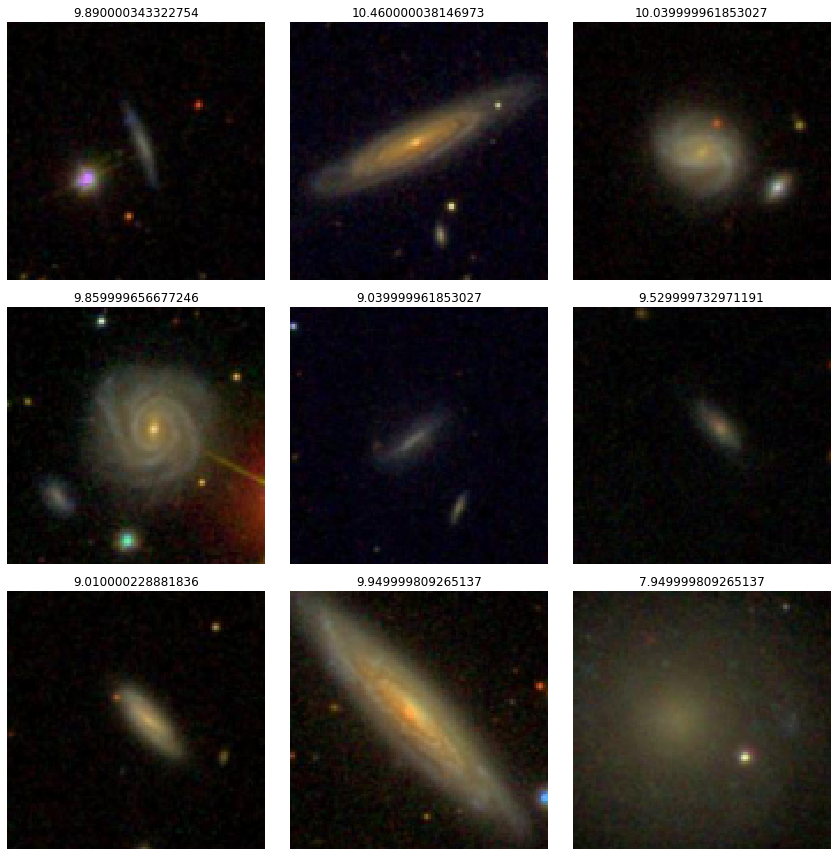

In [9]:
data.show_batch(3, figsize=(12, 12))

# Train simple convnet

In [10]:
defaults.device = torch.device('cpu')

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, pretrained=False):                  # pretrained kw is hardcoded into create_cnn
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32*32*32, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [25]:
# for some stupid reason this isn't working in my current version of fastai
def root_mean_squared_error(pred:Tensor, targ:Tensor)->Rank0Tensor:
    "Root mean squared error between `pred` and `targ`."
    return torch.sqrt(F.mse_loss(pred.flatten(), targ.flatten()))

In [26]:
learn = create_cnn(data, arch=SimpleCNN, pretrained=False, loss_func=root_mean_squared_error)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


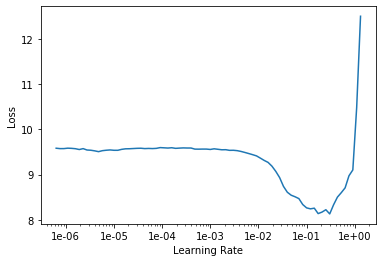

In [27]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(50, slice(1e-3, 3e-2))

epoch,train_loss,valid_loss
1,9.291012,9.518134
2,8.848627,8.528571
3,7.824750,4.812700
4,5.832916,3.447741
5,4.523387,1.831268
6,3.516999,1.218081
7,2.851605,0.840258
8,2.434372,0.731622
9,2.159950,0.848835
10,1.923014,1.008860


(0, 2)

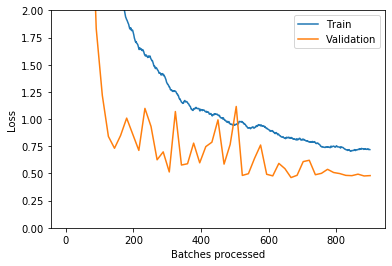

In [31]:
learn.recorder.plot_losses()
plt.ylim(0, 2)

# Visualize

(array([  2.,   3.,   5.,   7.,   8.,  35.,  75., 109., 114.,  20.]),
 array([ 6.66 ,  7.058,  7.456,  7.854,  8.252,  8.65 ,  9.048,  9.446,  9.844, 10.242, 10.64 ]),
 <a list of 10 Patch objects>)

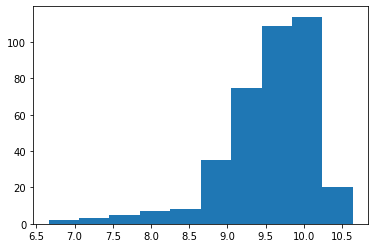

In [33]:
plt.hist(df.logMH)

In [35]:
HI_pred, HI_true = learn.TTA()

# store results, along with AGC identifier, in new DataFrame
results = pd.DataFrame({'HI_true': HI_true.squeeze(), 'HI_pred': HI_pred.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)

results.sample(3)

,HI_true,HI_pred
AGCNr,,
103581,9.76,9.133258
102559,9.40,9.215175
102731,9.50,9.521344


In [42]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def offset_image(objID, zoom=0.1):
    return OffsetImage(image2np(open_image(f'{PATH}/images/{objID}.jpg').data), zoom=zoom)

def plot_results(results, show_images=True):
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.scatter('HI_true', 'HI_pred', data=results, c='black')

    if show_images:
        artists = []
        for objID, [Z_true, Z_pred] in results.iterrows():
            ab = AnnotationBbox(offset_image(objID, zoom=0.4), (Z_true, Z_pred), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
            
    # plot 1:1 line
    plt.plot([6, 12], [6, 12], c='C3', ls='--', lw='10')

    ax.set_xlim(7, 11)
    ax.set_ylim(7, 11)
    ax.set_xlabel('True log HI')
    ax.set_ylabel('Pred log HI')



In [43]:
# how well did we do?
root_mean_squared_error(HI_pred, HI_true)

tensor(0.5047)

So we got 0.5 dex accuracy in logarithmic HI mass using 400 galaxies. Note that we've taken cutouts at the nearest optical positions! We may want to try doing the same at the ALFALFA positions...

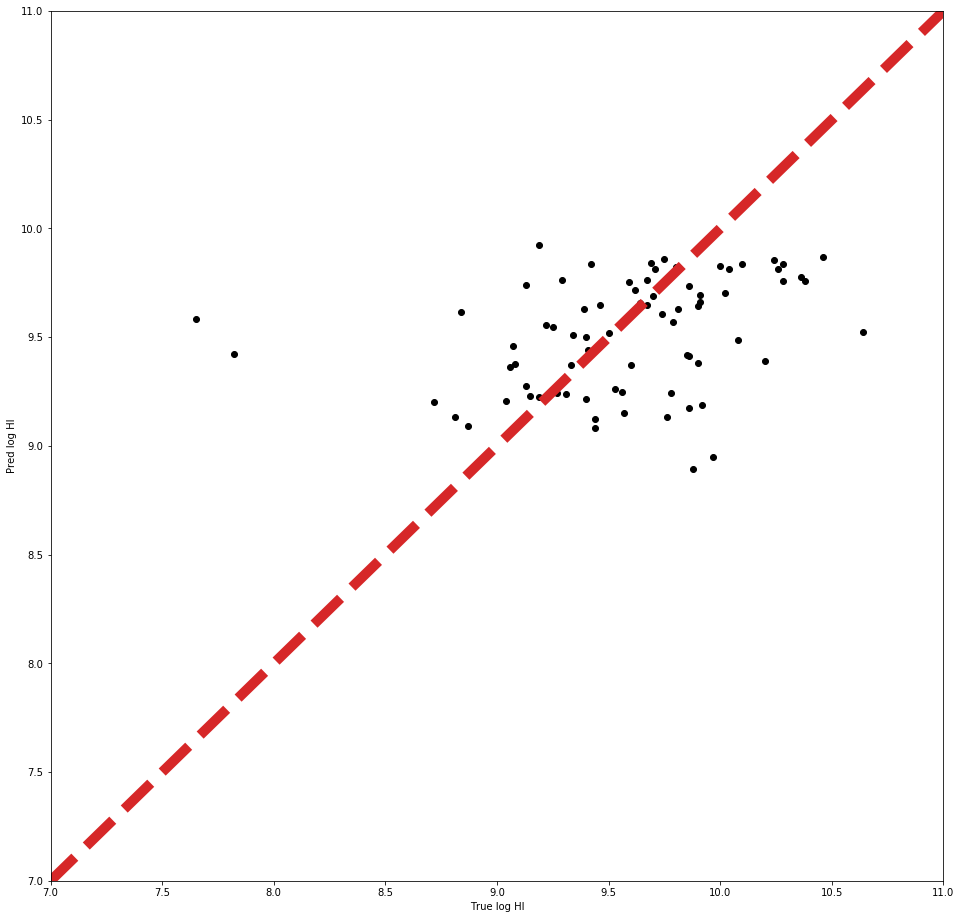

In [45]:
plot_results(results, show_images=False)

(8.5, 10.3)

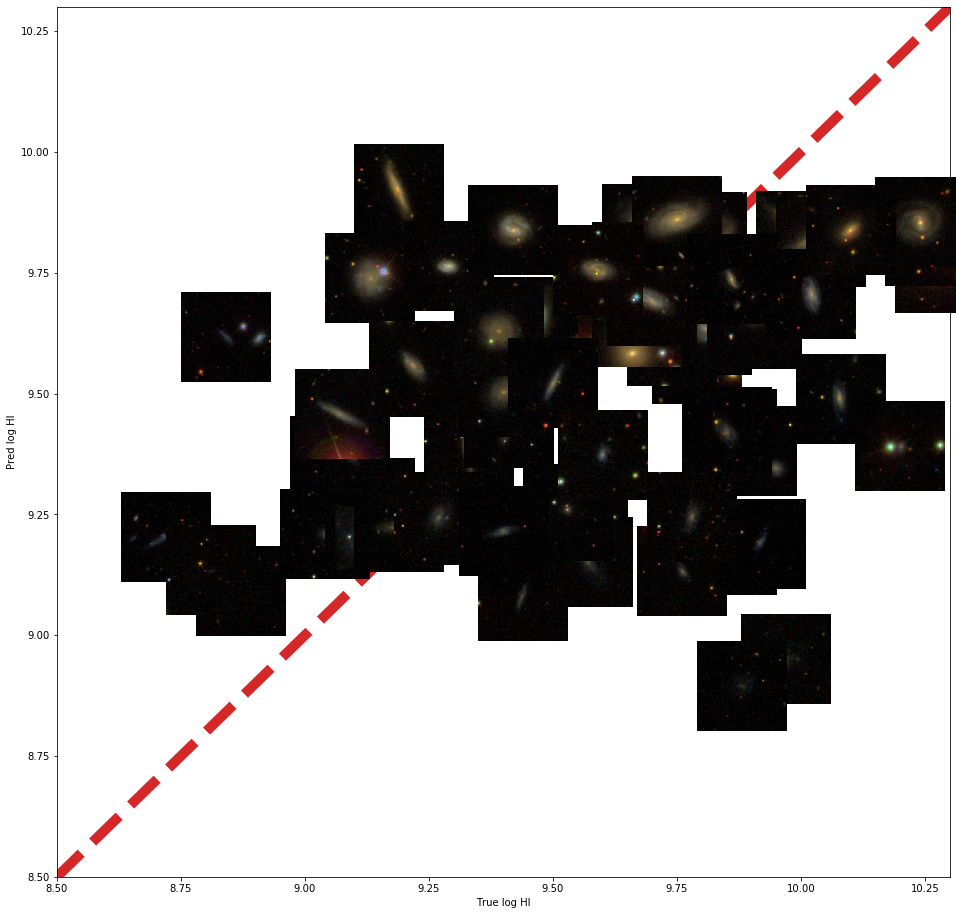

In [44]:
plot_results(results)
plt.xlim(8.5, 10.3)
plt.ylim(8.5, 10.3)

# Results

Yeah this isn't exactly the greatest result, but it's certainly tring to do something! Right now it seems to simply separate on the basis of flux. However, we can obviously supply more data, a better model, and give it more time to train. So perhaps this idea may be feasible!